# Water Quality and Potability Classification
  
#### [Dataset URL](https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability)
  
### Opis zbioru danych

Ten zbiór danych zawiera pomiary jakości wody oraz oceny dotyczące jej zdatności do spożycia przez ludzi, czyli potencjał pitności. Głównym celem tego zbioru danych jest dostarczenie wglądu w parametry jakości wody i pomoc w określeniu, czy woda jest zdatna do spożycia. Każdy wiersz w zbiorze danych reprezentuje próbkę wody z określonymi cechami, a kolumna "Potability" wskazuje, czy woda jest odpowiednia do spożycia. Głównym celem tego zbioru danych jest ocena i przewidywanie potencjału potabilności wody na podstawie cech jakości wody. Może być używany do oceny bezpieczeństwa i odpowiedniości źródeł wody do spożycia przez ludzi, podejmowania świadomych decyzji dotyczących uzdatniania wody oraz zapewnienia zgodności z normami jakości wody.

### Opis cech

- pH: Poziom pH wody.
- Hardness: Twardość wody, miara zawartości minerałów.
- Solids: Całkowita zawartość substancji rozpuszczonych w wodzie.
- Chloramines: Stężenie chloramin w wodzie.
- Sulfate: Stężenie siarczanów w wodzie.
- Conductivity: Przewodność elektryczna wody.
- Organic_carbon: Zawartość węgla organicznego w wodzie.
- Trihalomethanes: Stężenie trihalometanów w wodzie.
- Turbidity: Poziom mętności, miara klarowności wody.
- Potability: Zmienna celu; wskazuje zdatność do spożycia wody, przyjmując wartości 1 (zdatna do spożycia - "potable") i 0 (niezdatna do spożycia - "not potable).

### Parametry zbioru danych

- Liczba rekordów: 3276
- Liczba cech: 9
- Dane brakujące: Tak (kolumny: pH, Sulfate and Trihalomethanes)
- Dane odstające: Tak (ok. 1.22% całego zbioru danych) 
- Typ problemu: Klasyfikacja (Potability - No (0), Yes (1))

### Rozkład klas

| Klasa | Liczba rekordów | Rozkład procentowy |
|-------|-----------------|--------------------|
| 0     | 1998            | 60.99%             |
| 1     | 1278            | 39.01%             |

#### Importowanie bibliotek

In [13]:
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

#### Załadowanie zmiennych

Zmienne zostają załadowane z pliku wygenerowanego z notebooka DataAnalysis.ipynb przy pomocy biblioteki pickle, służącej do serializacji oraz deserializacji danych. Wybrano dane, które osiągnęły najlepsze wyniki podczas 2 etapu - tworzenia i trenowania modeli.

In [14]:
with open('data_dump/normalizedStdInterpolateVars.pkl', 'rb') as f:
    normalized_std_interpolate = pickle.load(f)
    scaler_std_interpolate = pickle.load(f)

#### Ustawienie ziarna losowości

Ustawiono ziarno losowości, aby wyniki były powtarzalne.

In [15]:
random_seed = 731202496
random.seed(random_seed)

#### Funkcje do podziału zbioru danych

Utworzono dwie funkcje do tworzenia podziału danych. Split_df_train_test odpowiada za podział danych na dwa zbiory: testowy i treningowy. Dane są dzielone z równomiernym podziałem klas, aby zapobiec sytuacji, w której podczas podziału danych, przydzielono do zbioru treningowego tylko jedną klasę danych. 

In [16]:
def split_df_train_test(data, test_size, seed):
    np.random.seed(seed)

    unique_labels = data['Potability'].unique()
    label_counts = data['Potability'].value_counts()

    test_indices = []

    for label in unique_labels:
        num_label_samples = label_counts[label]
        num_test_samples = int(test_size * num_label_samples)
        label_indices = data.index[data['Potability'] == label].tolist()
        label_test_indices = np.random.choice(label_indices, size=num_test_samples, replace=False)
        test_indices.extend(label_test_indices)

    train_indices = np.setdiff1d(data.index, test_indices)

    train_set = data.loc[train_indices]
    test_set = data.loc[test_indices]

    return train_set, test_set

#### Funkcje pomocniczne do obliczania F1 score oraz rysowania macierzy pomyłek

In [17]:
def calculate_f1_score(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))

    epsilon = 1e-7 
    precision_positives = true_positives / (true_positives + false_positives + epsilon)
    recall_positives = true_positives / (true_positives + false_negatives + epsilon)
    f1_score_positives = 2 * (precision_positives * recall_positives) / (precision_positives + recall_positives + epsilon)

    precision_negatives = true_negatives / (true_negatives + false_negatives + epsilon)
    recall_negatives = true_negatives / (true_negatives + false_positives + epsilon)
    f1_score_negatives = 2 * (precision_negatives * recall_negatives) / (precision_negatives + recall_negatives + epsilon)

    f1_score = (f1_score_positives + f1_score_negatives) / 2
    return f1_score

def plot_model_confusion_matrix(ax, model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(f'{model_name}')

#### Split danych

Podzielenie danych przy pomocy funkcji "split_df_train_test"

In [18]:
train_std_interpolate, test_std_interpolate = split_df_train_test(normalized_std_interpolate, 0.2, 123)

#### Podział klas po splicie - test/train

Dane zostały stratyfikowane, aby zachować równomierny podział klas w zbiorach treningowym i testowym.

In [19]:
train_class_counts = train_std_interpolate['Potability'].value_counts(normalize=True) * 100
test_class_counts = test_std_interpolate['Potability'].value_counts(normalize=True) * 100

print("Train set:")
print(train_class_counts)
print("\nTest set:")
print(test_class_counts)

Train set:
Potability
0    60.983982
1    39.016018
Name: proportion, dtype: float64

Test set:
Potability
0    61.009174
1    38.990826
Name: proportion, dtype: float64


#### Wybór modeli do optymalizacji

In [20]:
with open('data_dump/resultsBeforeOptimization.pkl', 'rb') as f:
    results_df = pickle.load(f)
    
results_df.sort_values(by='F1', ascending=False, inplace=True)

results_df

,Model,Accuracy,F1,Normalization,Missing Data
2,SVM,0.686544,0.609165,Std,Interpolate
5,SVM,0.686544,0.609165,Minmax,Interpolate
7,Random Forest,0.669725,0.607726,Std,Mean
10,Random Forest,0.669725,0.607726,Minmax,Mean
8,Random Forest,0.669725,0.605430,Std,Interpolate
11,Random Forest,0.669725,0.605430,Minmax,Interpolate
19,XGBoost,0.652905,0.603430,Std,Mean
22,XGBoost,0.652905,0.603430,Minmax,Mean
20,XGBoost,0.651376,0.591716,Std,Interpolate
23,XGBoost,0.651376,0.591716,Minmax,Interpolate


Na podstawie wyników z poprzedniego etapu, wybrano modele, które osiągnęły najlepsze wyniki. Zdecydowano się pominąć model SVM, ponieważ czas obliczeń był znacznie większy w porównaniu do innych modeli, natomiast zysk w jakości modelu nie był tak duży. Do optymalizacji wytypowano modele Random Forest oraz XGBoost. Modele te zostaną poddane optymalizacji hiperparametrów za pomocą algorytmów genetycznych, biblioteki Optuna oraz RandomizedSearchCV. Wyniki zostaną porównane pod kątem jakości modeli, czasu obliczeń oraz optymalizacji hiperparametrów.

#### Random Forest - Scikit-Learn

Poniżej zaimplementowano klasę RandomForestClassifierWrapper, która zawiera metody do trenowania modelu Random Forest oraz optymalizacji hiperparametrów za pomocą algorytmów genetycznych, biblioteki Optuna oraz RandomizedSearchCV. Klasa ta pozwala na porównanie wyników optymalizacji hiperparametrów za pomocą różnych metod dla modelu Random Forest.

In [21]:
class RandomForestClassifierWrapper:

    def __init__(self, train_set, test_set, optimize_f1_score, optimization_method):
        self.classifier_name = "Random Forest"
        self.optimization_method = optimization_method
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.test_pred = None
        self.hof = None
        self.best_optuna_trial = None
        self.best_score = None
        self.best_score_type = "F1 score" if optimize_f1_score else "accuracy"
        self.best_params = None
        self.processing_time = None
        self._create_model()

    # ----------------- DEAP -----------------
    def deap_objective(self, individual):
        n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion = individual
        n_estimators = int(n_estimators)
        max_depth = int(max_depth) if max_depth > 0 else None
        min_samples_split = int(min_samples_split) if int(min_samples_split) > 1 else 2
        min_samples_leaf = int(min_samples_leaf) if int(min_samples_leaf) > 0 else 1
        bootstrap = bool(bootstrap)
        criterion = 'gini' if criterion < 0.5 else 'entropy'
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       bootstrap=bootstrap, criterion=criterion, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score,

    def train_model_with_ga(self):
        if not hasattr(creator, 'FitnessMax'):
            creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        if not hasattr(creator, 'Individual'):
            creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_n_estimators", random.randint, 10, 200)
        toolbox.register("attr_max_depth", random.randint, 1, 50)
        toolbox.register("attr_min_samples_split", random.randint, 2, 10)
        toolbox.register("attr_min_samples_leaf", random.randint, 1, 10)
        toolbox.register("attr_bootstrap", random.randint, 0, 1)
        toolbox.register("attr_criterion", random.uniform, 0, 1)

        toolbox.register("individual", tools.initCycle, creator.Individual,
                         (toolbox.attr_n_estimators, toolbox.attr_max_depth, toolbox.attr_min_samples_split,
                          toolbox.attr_min_samples_leaf, toolbox.attr_bootstrap, toolbox.attr_criterion), n=1)

        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("evaluate", self.deap_objective)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=5)

        pop = toolbox.population(n=100)

        self.hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=30, lambda_=50, cxpb=0.5, mutpb=0.2,
                                                 ngen=5,
                                                 stats=stats, halloffame=self.hof, verbose=True)

        best_individual = tools.selBest(pop, 1)[0]

        self.model = RandomForestClassifier(n_estimators=int(best_individual[0]),
                                            max_depth=int(best_individual[1]),
                                            min_samples_split=int(
                                                best_individual[2] if int(best_individual[2]) > 1 else 2),
                                            min_samples_leaf=int(
                                                best_individual[3] if int(best_individual[3]) > 0 else 1),
                                            bootstrap=bool(best_individual[4]),
                                            criterion='gini' if best_individual[5] < 0.5 else 'entropy',
                                            random_state=random_seed)
        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_deap()

    def save_best_params_deap(self):
        self.best_params = {
            "n_estimators": int(self.hof[0][0]),
            "max_depth": int(self.hof[0][1]),
            "min_samples_split": int(self.hof[0][2]),
            "min_samples_leaf": int(self.hof[0][3]),
            "bootstrap": bool(self.hof[0][4]),
            "criterion": 'gini' if self.hof[0][5] < 0.5 else 'entropy'
        }

    # ----------------- Optuna -----------------
    def optuna_objective(self, trial):
        n_estimators = trial.suggest_int("n_estimators", 10, 200)
        max_depth = trial.suggest_int("max_depth", 1, 50)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        bootstrap = trial.suggest_categorical("bootstrap", [True, False])
        criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       bootstrap=bootstrap, criterion=criterion, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score

    def train_model_with_optuna(self, n_trials=100):
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: self.optuna_objective(trial), n_jobs=-1, n_trials=n_trials)

        self.best_optuna_trial = study.best_trial

        self.model = RandomForestClassifier(n_estimators=self.best_optuna_trial.params["n_estimators"],
                                            max_depth=self.best_optuna_trial.params["max_depth"],
                                            min_samples_split=self.best_optuna_trial.params["min_samples_split"],
                                            min_samples_leaf=self.best_optuna_trial.params["min_samples_leaf"],
                                            bootstrap=self.best_optuna_trial.params["bootstrap"],
                                            criterion=self.best_optuna_trial.params["criterion"],
                                            random_state=random_seed)
        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_optuna()

    def save_best_params_optuna(self):
        self.best_params = {
            "n_estimators": int(self.best_optuna_trial.params["n_estimators"]),
            "max_depth": int(self.best_optuna_trial.params["max_depth"]),
            "min_samples_split": int(self.best_optuna_trial.params["min_samples_split"]),
            "min_samples_leaf": int(self.best_optuna_trial.params["min_samples_leaf"]),
            "bootstrap": bool(self.best_optuna_trial.params["bootstrap"]),
            "criterion": self.best_optuna_trial.params["criterion"]
        }

    # ----------------- RandomizedSearchCV -----------------
    def train_model_CV(self):
        param_distributions = {
            "n_estimators": list(range(10, 201)),
            "max_depth": [None] + list(range(1, 51)),
            "min_samples_split": list(range(2, 11)),
            "min_samples_leaf": list(range(1, 11)),
            "bootstrap": [True, False],
            "criterion": ['gini', 'entropy']
        }

        if self.best_score_type == "F1 score":
            scoring = 'f1'
        else:
            scoring = 'accuracy'

        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, scoring=scoring,
                                           n_iter=12, cv=5, random_state=random_seed, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model_CV(self):
        self.set_best_score()
        self.save_best_params_CV()

    def set_best_score(self):
        self.test_pred = self.model.predict(self.test_set)
        if self.best_score_type == "F1 score":
            self.best_score = calculate_f1_score(self.test_label, self.test_pred)
        else:
            self.best_score = accuracy_score(self.test_label, self.test_pred)

    def save_best_params_CV(self):
        self.best_params = {
            "n_estimators": int(self.model.get_params()['n_estimators']),
            "max_depth": int(self.model.get_params()['max_depth']),
            "min_samples_split": int(self.model.get_params()['min_samples_split']),
            "min_samples_leaf": int(self.model.get_params()['min_samples_leaf']),
            "bootstrap": bool(self.model.get_params()['bootstrap']),
            "criterion": self.model.get_params()['criterion']
        }

    # ----------------- Other -----------------
    def _create_model(self):
        self.model = RandomForestClassifier(random_state=random_seed)

    def set_processing_time(self, end, start):
        self.processing_time = end - start

#### XGBoost

Zdecydowano się wykorzystać drugi model, który swoim działaniem jest podobny do modelu Random Forest. Pozwoli to porównać wyniki optymalizacji różnych modeli i wybrać ten najlepszy. Dodatkowo, model XGBoost jest znacząco szybszy od modelu Random Forest. Poniżej zaimplementowano klasę XGBoostClassifierWrapper, która zawiera metody do trenowania modelu XGBoost oraz optymalizacji hiperparametrów za pomocą algorytmów genetycznych, biblioteki Optuna oraz RandomizedSearchCV.

In [22]:
class XGBoostClassifierWrapper:

    def __init__(self, train_set, test_set, optimize_f1_score, optimization_method):
        self.classifier_name = "XGBoost"
        self.optimization_method = optimization_method
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.test_pred = None
        self.hof = None
        self.best_optuna_trial = None
        self.best_score = None
        self.best_score_type = "F1 score" if optimize_f1_score else "accuracy"
        self.best_params = None
        self.processing_time = None
        self._create_model()

    # ----------------- DEAP -----------------
    def deap_objective(self, individual):
        n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, learning_rate, reg_lambda, reg_alpha = individual
        n_estimators = int(n_estimators)
        max_depth = int(max_depth) if max_depth > 0 else None
        min_child_weight = int(min_child_weight) if int(min_child_weight) > 0 else 1
        gamma = max(0, gamma)
        subsample = min(max(0.1, subsample), 1)
        colsample_bytree = min(max(0.1, colsample_bytree), 1)
        learning_rate = min(max(0.01, learning_rate), 1)
        reg_lambda = max(0, reg_lambda)
        reg_alpha = max(0, reg_alpha)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                  min_child_weight=min_child_weight, gamma=gamma,
                                  subsample=subsample, colsample_bytree=colsample_bytree,
                                  learning_rate=learning_rate, reg_lambda=reg_lambda,
                                  reg_alpha=reg_alpha, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score,

    def train_model_with_ga(self):
        if not hasattr(creator, 'FitnessMax'):
            creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        if not hasattr(creator, 'Individual'):
            creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_n_estimators", random.randint, 10, 200)
        toolbox.register("attr_max_depth", random.randint, 1, 50)
        toolbox.register("attr_min_child_weight", random.randint, 1, 10)
        toolbox.register("attr_gamma", random.uniform, 0, 1)
        toolbox.register("attr_subsample", random.uniform, 0.1, 1)
        toolbox.register("attr_colsample_bytree", random.uniform, 0.1, 1)
        toolbox.register("attr_learning_rate", random.uniform, 0.01, 1)
        toolbox.register("attr_reg_lambda", random.uniform, 0, 1)
        toolbox.register("attr_reg_alpha", random.uniform, 0, 1)

        toolbox.register("individual", tools.initCycle, creator.Individual,
                         (toolbox.attr_n_estimators, toolbox.attr_max_depth, toolbox.attr_min_child_weight,
                          toolbox.attr_gamma, toolbox.attr_subsample, toolbox.attr_colsample_bytree,
                          toolbox.attr_learning_rate, toolbox.attr_reg_lambda, toolbox.attr_reg_alpha), n=1)

        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("evaluate", self.deap_objective)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=5)

        pop = toolbox.population(n=100)

        self.hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=30, lambda_=50, cxpb=0.5, mutpb=0.2,
                                                 ngen=5,
                                                 stats=stats, halloffame=self.hof, verbose=True)

        best_individual = tools.selBest(pop, 1)[0]

        self.model = xgb.XGBClassifier(n_estimators=int(best_individual[0]),
                                       max_depth=int(best_individual[1]),
                                       min_child_weight=int(best_individual[2] if int(best_individual[2]) > 0 else 1),
                                       gamma=max(0, best_individual[3]),
                                       subsample=min(max(0.1, best_individual[4]), 1),
                                       colsample_bytree=min(max(0.1, best_individual[5]), 1),
                                       learning_rate=min(max(0.01, best_individual[6]), 1),
                                       reg_lambda=max(0, best_individual[7]),
                                       reg_alpha=max(0, best_individual[8]),
                                       random_state=random_seed)

        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_deap()

    def save_best_params_deap(self):
        self.best_params = {
            "n_estimators": int(self.hof[0][0]),
            "max_depth": int(self.hof[0][1]),
            "min_child_weight": int(self.hof[0][2]),
            "gamma": self.hof[0][3],
            "subsample": self.hof[0][4],
            "colsample_bytree": self.hof[0][5],
            "learning_rate": self.hof[0][6],
            "reg_lambda": self.hof[0][7],
            "reg_alpha": self.hof[0][8]
        }

    # ----------------- Optuna -----------------
    def optuna_objective(self, trial):
        n_estimators = trial.suggest_int("n_estimators", 10, 200)
        max_depth = trial.suggest_int("max_depth", 1, 50)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
        gamma = trial.suggest_float("gamma", 0, 1)
        subsample = trial.suggest_float("subsample", 0.1, 1)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
        reg_lambda = trial.suggest_float("reg_lambda", 0, 1)
        reg_alpha = trial.suggest_float("reg_alpha", 0, 1)

        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                  min_child_weight=min_child_weight, gamma=gamma,
                                  subsample=subsample, colsample_bytree=colsample_bytree,
                                  learning_rate=learning_rate, reg_lambda=reg_lambda,
                                  reg_alpha=reg_alpha, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score

    def train_model_with_optuna(self, n_trials=100):
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: self.optuna_objective(trial), n_jobs=-1, n_trials=n_trials)

        self.best_optuna_trial = study.best_trial

        self.model = xgb.XGBClassifier(n_estimators=self.best_optuna_trial.params["n_estimators"],
                                       max_depth=self.best_optuna_trial.params["max_depth"],
                                       min_child_weight=self.best_optuna_trial.params["min_child_weight"],
                                       gamma=self.best_optuna_trial.params["gamma"],
                                       subsample=self.best_optuna_trial.params["subsample"],
                                       colsample_bytree=self.best_optuna_trial.params["colsample_bytree"],
                                       learning_rate=self.best_optuna_trial.params["learning_rate"],
                                       reg_lambda=self.best_optuna_trial.params["reg_lambda"],
                                       reg_alpha=self.best_optuna_trial.params["reg_alpha"],
                                       random_state=random_seed)
        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_optuna()

    def save_best_params_optuna(self):
        self.best_params = {
            "n_estimators": int(self.best_optuna_trial.params["n_estimators"]),
            "max_depth": int(self.best_optuna_trial.params["max_depth"]),
            "min_child_weight": int(self.best_optuna_trial.params["min_child_weight"]),
            "gamma": self.best_optuna_trial.params["gamma"],
            "subsample": self.best_optuna_trial.params["subsample"],
            "colsample_bytree": self.best_optuna_trial.params["colsample_bytree"],
            "learning_rate": self.best_optuna_trial.params["learning_rate"],
            "reg_lambda": self.best_optuna_trial.params["reg_lambda"],
            "reg_alpha": self.best_optuna_trial.params["reg_alpha"]
        }

    # ----------------- RandomizedSearchCV -----------------
    def train_model_CV(self):
        param_distributions = {
            "n_estimators": list(range(10, 201)),
            "max_depth": list(range(1, 51)),
            "min_child_weight": list(range(1, 11)),
            "gamma": [i / 10.0 for i in range(0, 5)],
            "subsample": [i / 10.0 for i in range(6, 10)],
            "colsample_bytree": [i / 10.0 for i in range(6, 10)],
            "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3],
            "reg_lambda": [i / 10.0 for i in range(0, 5)],
            "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100]
        }

        if self.best_score_type == "F1 score":
            scoring = 'f1'
        else:
            scoring = 'accuracy'

        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, scoring=scoring,
                                           n_iter=12, cv=5, random_state=random_seed, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model_CV(self):
        self.set_best_score()
        self.save_best_params_CV()

    def set_best_score(self):
        self.test_pred = self.model.predict(self.test_set)
        if self.best_score_type == "F1 score":
            self.best_score = calculate_f1_score(self.test_label, self.test_pred)
        else:
            self.best_score = accuracy_score(self.test_label, self.test_pred)

    def save_best_params_CV(self):
        self.best_params = {
            "n_estimators": int(self.model.get_params()['n_estimators']),
            "max_depth": int(self.model.get_params()['max_depth']),
            "min_child_weight": int(self.model.get_params()['min_child_weight']),
            "gamma": self.model.get_params()['gamma'],
            "subsample": self.model.get_params()['subsample'],
            "colsample_bytree": self.model.get_params()['colsample_bytree'],
            "learning_rate": self.model.get_params()['learning_rate'],
            "reg_lambda": self.model.get_params()['reg_lambda'],
            "reg_alpha": self.model.get_params()['reg_alpha']
        }

    # ----------------- Other -----------------
    def _create_model(self):
        self.model = xgb.XGBClassifier(random_state=random_seed)

    def set_processing_time(self, end, start):
        self.processing_time = end - start

#### Trenowanie modelu Random Forest - optymalizacja hiperparametrów za pomocą algorytmu genetycznego

Uruchomienie optymalizacji hiperparametrów modelu Random Forest za pomocą algorytmu genetycznego z wykorzystaniem biblioteki DEAP. W celach eksperymentalnych, optymalizację podzielono na dwie partie - optymalizacja accuracy oraz optymalizacja F1 score.

In [23]:
start_time = time.time()
RF_model_accuracy_optimizing_DEAP = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                  optimize_f1_score=False, optimization_method="DEAP")
RF_model_accuracy_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
RF_model_accuracy_optimizing_DEAP.set_processing_time(end_time, start_time)

start_time = time.time()
RF_model_f1score_optimizing_DEAP = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                 optimize_f1_score=True, optimization_method="DEAP")
RF_model_f1score_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
RF_model_f1score_optimizing_DEAP.set_processing_time(end_time, start_time)

gen	nevals	avg     	min     	max     
0  	100   	0.671422	0.610092	0.692661
1  	38    	0.684913	0.675841	0.692661
2  	36    	0.689042	0.686544	0.692661
3  	33    	0.692966	0.688073	0.700306
4  	38    	0.696126	0.692661	0.700306
5  	37    	0.698216	0.692661	0.700306
gen	nevals	avg     	min     	max     
0  	100   	0.589964	0.378917	0.642742
1  	33    	0.629281	0.579601	0.642742
2  	32    	0.638186	0.624936	0.650082
3  	33    	0.641662	0.636933	0.652348
4  	36    	0.646462	0.642742	0.653665
5  	38    	0.65108 	0.645642	0.653665


#### Trenowanie modelu Random Forest - optymalizacja hiperparametrów za pomocą biblioteki Optuna

Uruchomienie optymalizacji hiperparametrów modelu Random Forest za pomocą biblioteki Optuna.

In [24]:
start_time = time.time()
RF_model_accuracy_optimizing_optuna = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                    optimize_f1_score=False, optimization_method="Optuna")
RF_model_accuracy_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
RF_model_accuracy_optimizing_optuna.set_processing_time(end_time, start_time)

start_time = time.time()
RF_model_f1score_optimizing_optuna = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                   optimize_f1_score=True, optimization_method="Optuna")
RF_model_f1score_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
RF_model_f1score_optimizing_optuna.set_processing_time(end_time, start_time)

[I 2024-06-08 23:15:13,557] A new study created in memory with name: no-name-e2cec6d9-fa75-45f8-8330-c801ec93c9a0
[I 2024-06-08 23:15:14,876] Trial 5 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 10, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 5 with value: 0.6666666666666666.
[I 2024-06-08 23:15:15,892] Trial 13 finished with value: 0.6529051987767585 and parameters: {'n_estimators': 85, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 5 with value: 0.6666666666666666.
[I 2024-06-08 23:15:15,960] Trial 15 finished with value: 0.6376146788990825 and parameters: {'n_estimators': 129, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.6666666666666666.
[I 2024-06-08 23:15:16,414] Trial 16 finished with value: 0.6804281345565749 an

#### Trenowanie modelu Random Forest - optymalizacja hiperparametrów za pomocą RandomizedSearchCV

Uruchomienie optymalizacji hiperparametrów modelu Random Forest za pomocą biblioteki RandomizedSearchCV.

In [25]:
start_time = time.time()
RF_model_accuracy_optimizing_CV = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                optimize_f1_score=False, optimization_method="RandomizedSearchCV")
RF_model_accuracy_optimizing_CV.train_model_CV()
RF_model_accuracy_optimizing_CV.evaluate_model_CV()
end_time = time.time()
RF_model_accuracy_optimizing_CV.set_processing_time(end_time, start_time)

start_time = time.time()
RF_model_f1score_optimizing_CV = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                               optimize_f1_score=True, optimization_method="RandomizedSearchCV")
RF_model_f1score_optimizing_CV.train_model_CV()
RF_model_f1score_optimizing_CV.evaluate_model_CV()
end_time = time.time()
RF_model_f1score_optimizing_CV.set_processing_time(end_time, start_time)

#### Trenowanie modelu XGBoost - optymalizacja hiperparametrów za pomocą algorytmu genetycznego

Uruchomienie optymalizacji hiperparametrów modelu XGBoost za pomocą algorytmu genetycznego z wykorzystaniem biblioteki DEAP.

In [26]:
start_time = time.time()
XGB_model_accuracy_optimizing_DEAP = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                              optimize_f1_score=False, optimization_method="DEAP")
XGB_model_accuracy_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
XGB_model_accuracy_optimizing_DEAP.set_processing_time(end_time, start_time)

start_time = time.time()
XGB_model_f1score_optimizing_DEAP = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                             optimize_f1_score=True, optimization_method="DEAP")
XGB_model_f1score_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
XGB_model_f1score_optimizing_DEAP.set_processing_time(end_time, start_time)

gen	nevals	avg     	min     	max     
0  	100   	0.599343	0.513761	0.674312
1  	31    	0.635678	0.597859	0.663609
2  	34    	0.652701	0.610092	0.663609
3  	34    	0.658257	0.639144	0.665138
4  	34    	0.662895	0.66055 	0.666667
5  	31    	0.66682 	0.66055 	0.675841
gen	nevals	avg     	min     	max     
0  	100   	0.558442	0.451457	0.631992
1  	30    	0.602188	0.557879	0.626738
2  	41    	0.615805	0.59152 	0.633393
3  	37    	0.627837	0.62218 	0.63837 
4  	36    	0.632873	0.625315	0.63837 
5  	32    	0.638804	0.628409	0.645773


#### Trenowanie modelu XGBoost - optymalizacja hiperparametrów za pomocą biblioteki Optuna

Uruchomienie optymalizacji hiperparametrów modelu XGBoost za pomocą biblioteki Optuna.

In [27]:
start_time = time.time()
XGB_model_accuracy_optimizing_optuna = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                optimize_f1_score=False, optimization_method="Optuna")
XGB_model_accuracy_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
XGB_model_accuracy_optimizing_optuna.set_processing_time(end_time, start_time)

start_time = time.time()
XGB_model_f1score_optimizing_optuna = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                               optimize_f1_score=True, optimization_method="Optuna")
XGB_model_f1score_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
XGB_model_f1score_optimizing_optuna.set_processing_time(end_time, start_time)

[I 2024-06-08 23:19:18,854] A new study created in memory with name: no-name-f5b6c47d-208c-45f2-9c9d-a6393b3cd0b7
[I 2024-06-08 23:19:19,057] Trial 4 finished with value: 0.6024464831804281 and parameters: {'n_estimators': 20, 'max_depth': 44, 'min_child_weight': 7, 'gamma': 0.972453157051304, 'subsample': 0.5141183864852253, 'colsample_bytree': 0.9820741674344597, 'learning_rate': 0.5352134146314287, 'reg_lambda': 0.14657659680637936, 'reg_alpha': 0.9838374272717376}. Best is trial 4 with value: 0.6024464831804281.
[I 2024-06-08 23:19:19,092] Trial 1 finished with value: 0.6116207951070336 and parameters: {'n_estimators': 23, 'max_depth': 37, 'min_child_weight': 9, 'gamma': 0.49830694480583004, 'subsample': 0.9431386237563879, 'colsample_bytree': 0.4712670212254292, 'learning_rate': 0.9963145853944334, 'reg_lambda': 0.5245454990477822, 'reg_alpha': 0.798265728069444}. Best is trial 1 with value: 0.6116207951070336.
[I 2024-06-08 23:19:19,147] Trial 6 finished with value: 0.60244648318

#### Trenowanie modelu XGBoost - optymalizacja hiperparametrów za pomocą RandomizedSearchCV

Uruchomienie optymalizacji hiperparametrów modelu XGBoost za pomocą biblioteki RandomizedSearchCV.

In [28]:
start_time = time.time()
XGB_model_accuracy_optimizing_CV = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                            optimize_f1_score=False, optimization_method="RandomizedSearchCV")
XGB_model_accuracy_optimizing_CV.train_model_CV()
XGB_model_accuracy_optimizing_CV.evaluate_model_CV()
end_time = time.time()
XGB_model_accuracy_optimizing_CV.set_processing_time(end_time, start_time)

start_time = time.time()
XGB_model_f1score_optimizing_CV = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                           optimize_f1_score=True, optimization_method="RandomizedSearchCV")
XGB_model_f1score_optimizing_CV.train_model_CV()
XGB_model_f1score_optimizing_CV.evaluate_model_CV()
end_time = time.time()
XGB_model_f1score_optimizing_CV.set_processing_time(end_time, start_time)

#### Zebranie wyników

In [29]:
models = [RF_model_accuracy_optimizing_DEAP, RF_model_f1score_optimizing_DEAP,
        RF_model_accuracy_optimizing_optuna, RF_model_f1score_optimizing_optuna,
        RF_model_accuracy_optimizing_CV, RF_model_f1score_optimizing_CV,
        XGB_model_accuracy_optimizing_DEAP, XGB_model_f1score_optimizing_DEAP,
        XGB_model_accuracy_optimizing_optuna, XGB_model_f1score_optimizing_optuna,
        XGB_model_accuracy_optimizing_CV, XGB_model_f1score_optimizing_CV]

#### Macierze pomyłek

Wyrysowanie macierzy pomyłek dla każdego z przetestoanych modeli.

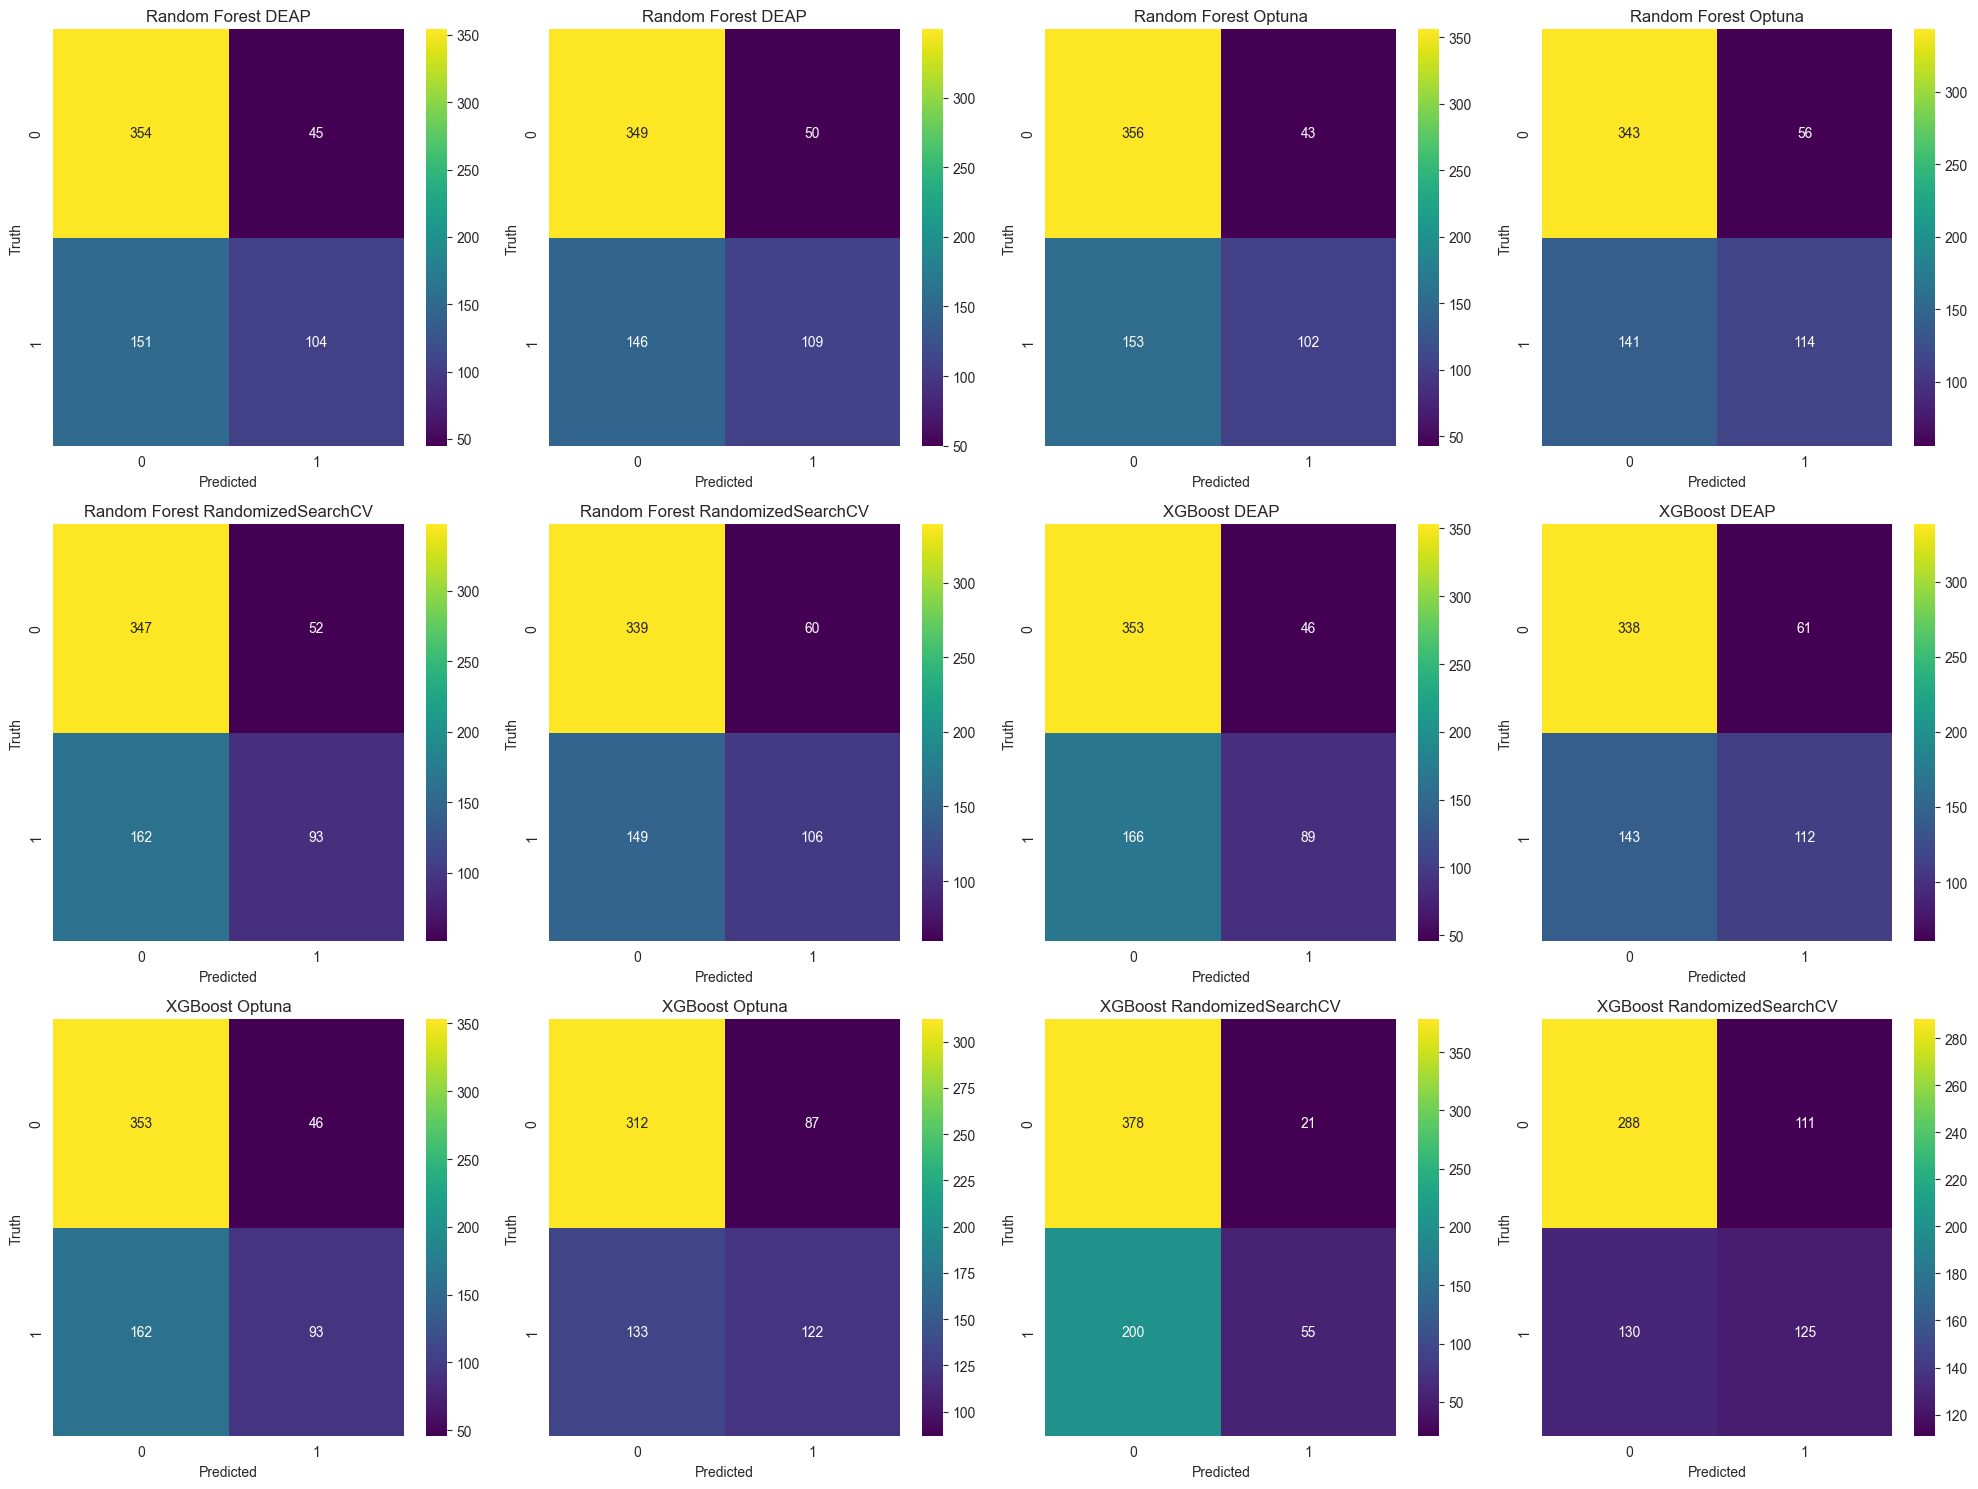

In [30]:
fig, axs = plt.subplots(3, 4, figsize=(20,15))

for i, model in enumerate(models):
    plot_model_confusion_matrix(axs[i//4, i%4], model.model, model.test_set, model.test_label, f'{model.classifier_name} {model.optimization_method}')

plt.tight_layout()
plt.show()

#### Ogólna tabela wyników po optymalizacji

In [31]:
data = []
for model in models:
    data.append([model.classifier_name, model.optimization_method, model.best_score, model.best_score_type, model.best_params, model.processing_time])

optimized_results_df = pd.DataFrame(data, columns=['Model Name', 'Optimization Method', 'Best Score', 'Score Type', 'Best Parameters', 'Processing Time [s]'])
    
optimized_results_df

,Model Name,Optimization Method,Best Score,Score Type,Best Parameters,Processing Time [s]
0,Random Forest,DEAP,0.700306,accuracy,"{'n_estimators': 195, 'max_depth': 25, 'min_sa...",568.645127
1,Random Forest,DEAP,0.653665,F1 score,"{'n_estimators': 186, 'max_depth': 24, 'min_sa...",695.684405
2,Random Forest,Optuna,0.700306,accuracy,"{'n_estimators': 110, 'max_depth': 35, 'min_sa...",40.965717
3,Random Forest,Optuna,0.656684,F1 score,"{'n_estimators': 116, 'max_depth': 32, 'min_sa...",47.598335
4,Random Forest,RandomizedSearchCV,0.672783,accuracy,"{'n_estimators': 138, 'max_depth': 40, 'min_sa...",10.259647
5,Random Forest,RandomizedSearchCV,0.633969,F1 score,"{'n_estimators': 106, 'max_depth': 35, 'min_sa...",14.651742
6,XGBoost,DEAP,0.675841,accuracy,"{'n_estimators': 91, 'max_depth': 16, 'min_chi...",79.026224
7,XGBoost,DEAP,0.645773,F1 score,"{'n_estimators': 184, 'max_depth': 28, 'min_ch...",52.762992
8,XGBoost,Optuna,0.681957,accuracy,"{'n_estimators': 157, 'max_depth': 14, 'min_ch...",5.069058
9,XGBoost,Optuna,0.632599,F1 score,"{'n_estimators': 105, 'max_depth': 40, 'min_ch...",5.821455


#### Najlepszy wynik modeli Random Forest i XGBoost przed optymalizacją

In [32]:
filtered_df_before_opt = results_df.loc[(results_df['Model'].isin(['Random Forest', 'XGBoost'])) & (results_df['Normalization'] == 'Std') & (results_df['Missing Data'] == 'Interpolate')]
filtered_df_before_opt = filtered_df_before_opt.drop(columns=['Normalization', 'Missing Data'])

filtered_df_before_opt

,Model,Accuracy,F1
8,Random Forest,0.669725,0.605430
20,XGBoost,0.651376,0.591716


#### Najlepszy wynik modeli Random Forest i XGBoost po optymalizacji

In [33]:
best_accuracy_RF_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'Random Forest') & (optimized_results_df['Score Type'] == 'accuracy')].sort_values(by='Best Score', ascending=False).iloc[0]
best_f1score_RF_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'Random Forest') & (optimized_results_df['Score Type'] == 'F1 score')].sort_values(by='Best Score', ascending=False).iloc[0]
best_accuracy_XGB_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'XGBoost') & (optimized_results_df['Score Type'] == 'accuracy')].sort_values(by='Best Score', ascending=False).iloc[0]
best_f1score_XGB_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'XGBoost') & (optimized_results_df['Score Type'] == 'F1 score')].sort_values(by='Best Score', ascending=False).iloc[0]

best_rows = pd.concat([best_accuracy_RF_row, best_f1score_RF_row, best_accuracy_XGB_row, best_f1score_XGB_row], axis=1).transpose()
best_rows

,Model Name,Optimization Method,Best Score,Score Type,Best Parameters,Processing Time [s]
0,Random Forest,DEAP,0.700306,accuracy,"{'n_estimators': 195, 'max_depth': 25, 'min_sa...",568.645127
3,Random Forest,Optuna,0.656684,F1 score,"{'n_estimators': 116, 'max_depth': 32, 'min_sa...",47.598335
8,XGBoost,Optuna,0.681957,accuracy,"{'n_estimators': 157, 'max_depth': 14, 'min_ch...",5.069058
7,XGBoost,DEAP,0.645773,F1 score,"{'n_estimators': 184, 'max_depth': 28, 'min_ch...",52.762992


#### Porównanie wyników przed i po optymalizacji dla modeli Random Forest i XGBoost

In [34]:
final_data = {
    "Model Name": ['Random Forest', 'XGBoost'],
    "Before Optimization Accuracy": [filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'Accuracy'].values[0],
                                    filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'Accuracy'].values[0]],
    "After Optimization Accuracy": [best_accuracy_RF_row['Best Score'], best_accuracy_XGB_row['Best Score']],
    "Difference Accuracy": [best_accuracy_RF_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'Accuracy'].values[0],
                            best_accuracy_XGB_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'Accuracy'].values[0]],  
    "Before Optimization F1 Score": [filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'F1'].values[0],
                                    filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'F1'].values[0]],
    "After Optimization F1 Score": [best_f1score_RF_row['Best Score'], best_f1score_XGB_row['Best Score']],
    "Difference F1 Score": [best_f1score_RF_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'F1'].values[0],
                            best_f1score_XGB_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'F1'].values[0]]
}

final_results_df = pd.DataFrame(final_data)
final_results_df

,Model Name,Before Optimization Accuracy,After Optimization Accuracy,Difference Accuracy,Before Optimization F1 Score,After Optimization F1 Score,Difference F1 Score
0,Random Forest,0.669725,0.700306,0.030581,0.605430,0.656684,0.051254
1,XGBoost,0.651376,0.681957,0.030581,0.591716,0.645773,0.054058


### Wybranie najlepszego modelu

In [35]:
best_accuracy_model = optimized_results_df.loc[optimized_results_df['Score Type'] == 'accuracy'].sort_values(by='Best Score', ascending=False).iloc[0]
best_f1score_model = optimized_results_df.loc[optimized_results_df['Score Type'] == 'F1 score'].sort_values(by='Best Score', ascending=False).iloc[0]

#### Najlepszy model pod kątem Accuracy

In [36]:
best_accuracy_model

Model Name                                                 Random Forest
Optimization Method                                                 DEAP
Best Score                                                      0.700306
Score Type                                                      accuracy
Best Parameters        {'n_estimators': 195, 'max_depth': 25, 'min_sa...
Processing Time [s]                                           568.645127
Name: 0, dtype: object

#### Najlepszy model pod kątem F1 Score

In [37]:
best_f1score_model

Model Name                                                 Random Forest
Optimization Method                                               Optuna
Best Score                                                      0.656684
Score Type                                                      F1 score
Best Parameters        {'n_estimators': 116, 'max_depth': 32, 'min_sa...
Processing Time [s]                                            47.598335
Name: 3, dtype: object

#### Macierze pomyłek dla najlepszych modeli pod kątem accuracy i F1 Score

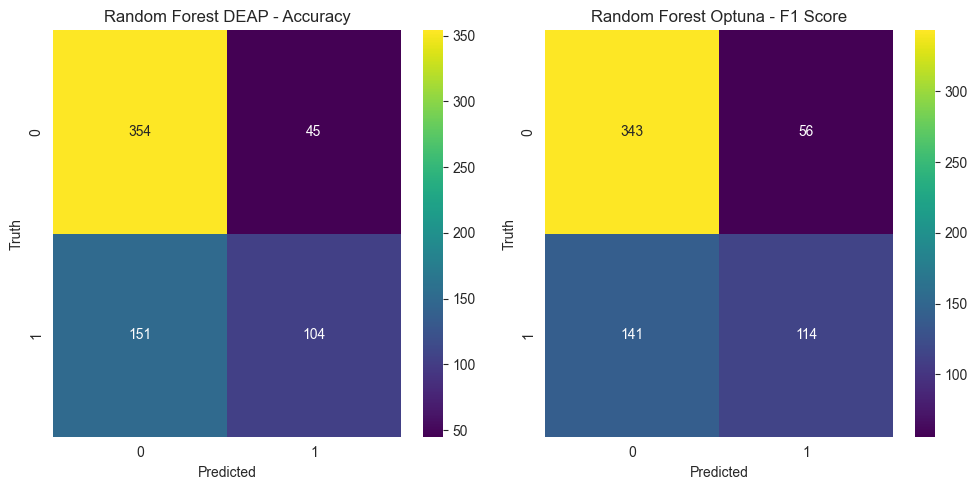

In [38]:
models_sorted_by_accuracy = sorted(models, key=lambda x: x.best_score if x.best_score_type == "accuracy" else 0, reverse=True)
best_accuracy_models = models_sorted_by_accuracy[:1]

models_sorted_by_f1 = sorted(models, key=lambda x: x.best_score if x.best_score_type == "F1 score" else 0, reverse=True)
best_f1_models = models_sorted_by_f1[:1]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

plot_model_confusion_matrix(axs[0], best_accuracy_models[0].model, best_accuracy_models[0].test_set, best_accuracy_models[0].test_label, f'{best_accuracy_models[0].classifier_name} {best_accuracy_models[0].optimization_method} - Accuracy')
plot_model_confusion_matrix(axs[1], best_f1_models[0].model, best_f1_models[0].test_set, best_f1_models[0].test_label, f'{best_f1_models[0].classifier_name} {best_f1_models[0].optimization_method} - F1 Score')

plt.tight_layout()
plt.show()

### Podsumowanie

Optymalizując hiperparametry modeli, udało się uzyskać zysk w skuteczności zarówno dla metryki Accuracy jak i F1 Score. 

Najlepszym modelem pod kątem optymalizacji Accuracy okazał się model Random Forest, który uzyskał skuteczność na poziomie 70.03%. Jest to wzrost o około 3 punkty procentowe w stosunku do modelu przed optymalizacją - 66.97%. Ten konkretnie model, był optymalizowany za pomocą algorytmu genetycznego (biblioteka DEAP). Najlepsze hiperparametry dla tego modelu to:

- n_estimators: 195, 
- max_depth: 25, 
- min_samples_split: 5, 
- min_samples_leaf: 1, 
- bootstrap: True, 
- criterion: 'entropy'

Reszta hiperparametrów modelu została w ustawieniu domyślnym. W tym przypadku biblioteka DEAP okazała się najbardziej skuteczna, natomiast czas obliczeń był zdecydowanie największy. Wykonanie zrównoleglenia przy przeprowadzaniu obliczeń z bibloteką DEAP jest znacznie utrudnione, ze względu na wykorzystanie Jupyter Notebook'a, co jest głównym powodem długiego czasu obliczeń. Model XGBoost w tym przypadku spisał się znacznie lepiej. Nawet bez zrównoleglenia, algorytm genetyczny był w stanie zoptymalizować 9 hiperparametrów w stosunkowo krótkim czasie, tj. około 1 minuty. Połączenie DEAP z Random Forest sprawiło natomiast, że czas obliczeń wyniósł około 10 minut, mimo, że optymalizowane było tylko 6 hiperparametrów.

Do celów eksperymentalnych zdecydowano się również zoptymalizować metrykę F1 Score. W tym przypadku najlepszym modelem również okazał się Random Forest, osiągając wynik ok. 65.67%, co jest wzrostem o około 5.1 pp w stosunku do wyniku sprzed optymalizacji (60.54%). Najlepsze hiperparametry dla tego modelu to:

- n_estimators: 116,
- max_depth: 32,
- min_samples_split: 10,
- min_samples_leaf: 1,
- bootstrap: False,
- criterion: 'gini'

W tym przypadku, nieznacznie lepsza okazała się biblioteka Optuna. Czas obliczeń był znaczący krótszy niż w przypadku DEAP - około 1 minuty.

Wynik na poziomie 70% wydaje się dosyć dobry, biorąc pod uwagę fakt małej liczby danych, które były do dyspozycji - około 3200 rekordów. Należy jednak zwrócić uwagę, że klasy rozkładały się w stosunku 60:40, co mogło wpłynąć nieznacznie na wynik. 60% skuteczności jest to wartość, którą powinno się traktować jako referencyjną - w momencie gdy dane rozłożone są w stosunku 60/40, to bardzo łatwo jest uzyskać klasyfikator, który osiągnie 60% skuteczności - wystarczy, że będzie on zawsze przewidywał klasę większościową.